#### 2. Подход с **valence-arousal** разложением эмоций.

В первую очередь необходимо отметить, что для обучения модели в valence-arousal разложением эмоций необходимо разметка фотографий по этим параметрам. В предоставленном дата-сете такой разметки нет. Можно каждую из 9 эмоций представить в виде пары чисел (valence, arousal), но это не будет отражать действительности, так как в пределах одной категории сила эмоций может варьироваться.

В качестве компромисной меры создадим модель в двумя головами: обычный классификатор и регрессор. Добавим больше веса классификатору, так как не хотим, чтобы некорректные входные данные по разложению вносили сильные искажения в сверточные слои.

В качестве основы возьмем BiT-M r50x1 модель.

На основании [статьи](https://www.mdpi.com/2076-3417/11/3/1338/htm) в качестве примера сделаем следующее разложение по valence-arousal:

In [1]:
# fisrt number - valence, second - arousal
VA_domains = {
    'anger':    [  -3,   1],
    'contempt': [-1.5,   0],
    'disgust':  [  -1,-1.8],
    'fear':     [  -1,   3],
    'happy':    [   4,   1],
    'neutral':  [   0,   0],
    'sad':      [-3.5,  -2],
    'surprise': [   3,   2],
    'uncertain':[   0,  -2]
}

In [2]:
import tensorflow as tf
print('tensorflow version', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot.tf_keras import PlotLossesCallback

import tensorflow_hub as hub
import numpy as np
import pandas as pd
import time
from pathlib import Path
from matplotlib import pyplot as plt
from misc.custom_filters import random_transformation
from tqdm.notebook import tqdm

plt.rcParams['figure.facecolor'] = 'white' # for better plots in dark notebook themes

tensorflow version 2.4.1


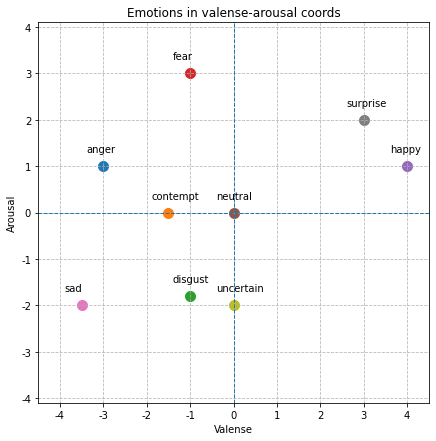

In [18]:
def emotion_plot(VA_domains):
    plt.figure(figsize=(7,7))
    for category, (v, a) in VA_domains.items():
        plt.scatter(v, a, label=category, s=100)
        plt.text(v-0.4, a+0.3, category)
    xmin, xmax = plt.xlim(-4.5, 4.5)
    ymin, ymax = plt.ylim(-4.1, 4.1)
    plt.vlines(0, ymin, ymax, linestyle='dashed', lw=1)
    plt.hlines(0, xmin, xmax, linestyle='dashed', lw=1)
    # plt.legend(bbox_to_anchor=(1.3, 1))
    plt.xticks(range(-4,5), range(-4,5))
    plt.yticks(range(-4,5), range(-4,5))
    plt.grid(alpha=0.9, linestyle='--')
    plt.xlabel('Valense')
    plt.ylabel('Arousal')
    plt.title('Emotions in valense-arousal coords')
    plt.show()

emotion_plot(VA_domains)

Создадим вспомогательные функции для загрузки датасета и тестирования модели.

In [4]:
def load_dataset(n, batch_size, image_size, va_df=None):
    """
    Create image generators for train and test data with specified parameters.
    """
    base_dir = Path('dataset')
    df_train = pd.read_pickle(base_dir / f'dataframe_case{n}_train.pkl')
    df_test = pd.read_pickle(base_dir / f'dataframe_case{n}_test.pkl')

    if n == 1:
        image_generator = ImageDataGenerator(
            rescale=1./255, 
            rotation_range=15, 
            width_shift_range=0.15,
            height_shift_range=0.10,
            brightness_range=(0.6, 1.4),
            shear_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
            preprocessing_function=random_transformation,
        )
    elif n == 2:
        image_generator = ImageDataGenerator(
            rescale=1./255, 
            rotation_range=15, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            brightness_range=(0.6, 1.4),
            shear_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
            preprocessing_function=random_transformation,
        )
    else:
        raise ValueError('n should be integer and equal to 1 or 2.')
    
    val_generator = ImageDataGenerator(rescale=1./255)

    train_data_gen = image_generator.flow_from_dataframe(
        df_train,
        directory=base_dir,
        x_col='image_path',
        y_col='emotion',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
        interpolation='bicubic',
        validate_filenames=False,
    )
    val_data_gen = val_generator.flow_from_dataframe(
        df_test,
        directory=base_dir,
        x_col='image_path',
        y_col='emotion',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True, # useful if we limit validation steps
        interpolation='bicubic',
        validate_filenames=False,
    )
    
    assert train_data_gen.class_indices == val_data_gen.class_indices, "Class labels doesn't match between train and test sets."
    labels_dict = {v: k for k,v in train_data_gen.class_indices.items()}
    
    return train_data_gen, val_data_gen, labels_dict


def benchmark_model(model, sample, iterations=200):
    """Test inference time of the model."""
    model(sample) # warm-up inference
    inference_times = []
    for i in range(iterations):
        start = time.time()
        model(sample)
        inference_times.append(time.time() - start)
    mean_time = np.mean(inference_times)
    median_time = np.median(inference_times)
    plt.plot(inference_times)
    plt.title(f'Inference time over {iterations} iterations on one picture\n'
              f'mean time = {mean_time:.3f}sec, median time = {median_time:.3f}sec')
    plt.xlabel('Iteration number')
    plt.ylabel('Inference time, sec')
    plt.show()
    return mean_time, median_time


# Так как модель будет двух-главая, то необходимо предоставить два целевых показателя: 
# класс и пару чисел (valence, arousal). Для этого к нашему генератору добавим обертку, 
# которая для каждого объекта выборки из метки класса будет создавать пару 
# (valence, arousal) на основании ранее определенного словаря `VA_domains`.
class ImageGeneratorVA(tf.keras.utils.Sequence):

    def __init__(self, data_gen, va_domains, two_heads=True):
        """
        inputs:
            data_gen - instantiated flow of TF ImageDataGenerator
            va_domains - dictionary {<emotion_name>: [valense, arousal]}
            number of classes detected by data_gen must match with number
            of keys in va_domains dict.
            two_head - True/False flag to determine if generator returns
            one-hot classes target + valence_arousal target (True) OR
            just valence_arousal target (False)
        """
        # copy image generator
        self.gen = data_gen
        # add possibility to return class and va-values OR just va_values
        self.two_heads = two_heads
        # create dict where key - class integer, value - pair of (val, aro)
        self.va_table = {data_gen.class_indices[k]:v for k, v in va_domains.items()}
        # for concistency of generator usage in later code
        self.class_indices = self.gen.class_indices
        # tensors for keys, valences and arousals. 
        # keys() always corresponds to values(), thus order of elems is consistent
        keys_tensor = tf.constant(list(self.va_table.keys()), dtype=tf.int64)
        val_tensor = tf.constant([x[0] for x in self.va_table.values()])
        aro_tensor = tf.constant([x[1] for x in self.va_table.values()])
        
        # create Hash table by tensorflow like {class integer: valence value}.
        # I used hash tables as I tried to fit this logic in custom loss function
        # so all done in TF functions. Eventually custom_loss didn't work 
        # with model.fit, so I just copy paste it to generator.
        self.val_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys_tensor, val_tensor),
            default_value=-1)
        # create Hash table by tensorflow {class integer: arousal value}
        self.aro_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys_tensor, aro_tensor),
            default_value=-1)

    def __len__(self):
        """mandatory method"""
        return len(self.gen)

    def __getitem__(self, idx):
        """mandatory method"""
        # generate batch of images and labels (as one-hot) from ImageDataGenerator
        x, y = next(self.gen) # could be self.gen[idx] instead but data is suffled anyway
        # covert y-tensor (batch, 9) to va_tensor (batch, 2), in other words \
        # convert one-hot classes to (valence, arousal) pairs for every sample in batch
        cat_tensor = tf.argmax(y, axis=-1)
        valence_tensor = self.val_table.lookup(cat_tensor)
        arousal_tensor = self.aro_table.lookup(cat_tensor)
        va_tensor = tf.stack([valence_tensor, arousal_tensor], axis=1)
        
        # return tuple of rank 2, so first element is batch of images
        # second element is dict of targets for both model outputs
        if self.two_heads:
            return x, {'cat_output': y, 'va_output': va_tensor}
        else:
            return x, va_tensor
        

        
# Напишем свою метрику, которая определяет класс эмоции по кратчайшему 
# растоянию по одного из центров эмоций (`VA_domains`) и на основании 
# этого считает привычную нас CategoricalAccuracy.        
# from tensorflow.python.training.tracking.data_structures import NoDependency
# ошибка - словарь содержит нестроковые ключи. Model не сохраняется...
class DistanceVAMetric(tf.keras.metrics.Metric):
    
    def __init__(self, va_table, name="va_distance_metric", **kwargs):
        """
        Converts (valense, arousal) to emotion labels (for y_true) and 
        logits (for y_pred) and calculates Categorical Accuracy metric.
        """
        super(DistanceVAMetric, self).__init__(name=name, **kwargs)
        self.metric = tf.keras.metrics.SparseCategoricalAccuracy()
#         self.va_table = NoDependency(va_table)
        self.va_table = {str(k):v for k,v in va_table.items()}

        
    def update_state(self, y_true, y_pred, sample_weight=None):
        """      
        Inputs:
            y_true: (batch, 2) - valence,arousal true values
            y_pred: (batch, 2) - valence,arousal predicted values
        """
        # get logits for predicted (valence, arousal) coords
        va_like_logits = self._logits_from_va(y_pred)
        y_true_sparse = tf.argmax(self._logits_from_va(y_true), axis=1)
        
        self.metric.update_state(y_true_sparse, va_like_logits)

        
    def result(self):
        return self.metric.result()

    
    def reset_states(self):
        self.metric.reset_states()
    
    
    def _logits_from_va(self, va_predictions):
        """
        input:
            va_predictions has shape (batch, 2), for example prediction 
            from a regressor head of model with valense, arousal predictions.
        output: 
            tensor with shape (batch, 9) - 9 values, similar to logits 
            values for every of 9 classes. In fact, it is 
            exp(-distance), where distance is euclidian distance between
            provided (valense, arousal) values and emotion center coordinates,
            stored in va_table for each of 9 classes.
        """
        class_distances = []
        # iterate by range generator to guarantee ascending order of classes
        for j in range(len(self.va_table.keys())):
            # coords of emotion's center
            node_ = tf.constant(self.va_table[str(j)], dtype=tf.float32)
            # distances to the emo-center for all samples in batch
            distance = tf.sqrt(tf.reduce_sum(tf.square(va_predictions - node_), axis=1))
            class_distances.append(distance)

        distances_tensor = tf.stack(class_distances, axis=1)
        va_like_logits = tf.exp(-distances_tensor)

        return va_like_logits

In [20]:
BATCH_SIZE = 64
IMG_SIZE = 240

train_data, val_data, labels_dict = load_dataset(
    n=1, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE
)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.


In [6]:
# create instances of our custom generators for train and validation sets
train_data_gen = ImageGeneratorVA(train_data, VA_domains)
val_data_gen = ImageGeneratorVA(val_data, VA_domains)

Так как модель двухглавая, создаем её с помощью tensorflow functional API. Обязательно задаем правильные имена выходов, которые везде будем использовать (в ImageGeneratorVA, losses, metrics, etc.). Воспользуемся BiT-HyperRule для дообучения модели, но с небольшим изменением: множитель для learning rate возьмем не 1/10, а 1/5. В остальном, всё как и прежде.

In [7]:
N_CLASSES = len(train_data_gen.class_indices)

# if True:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')
embed = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True)
cat_fc = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='cat_output', kernel_initializer='zeros')
va_fc = tf.keras.layers.Dense(2, name='va_output', kernel_initializer='zeros')

out = embed(inputs)
cat_output = cat_fc(out)
va_output = va_fc(out)
model = tf.keras.Model(inputs=[inputs], outputs=[cat_output, va_output])

# BiT HyperRule
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 2000 * 512 / BATCH_SIZE # 11 epochs = 50% of SCHEDULE_LENGTH
SCHEDULE_BOUNDARIES = [int(SCHEDULE_LENGTH * x) for x in [0.3, 0.6, 0.9]] 
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES, 
    values=[lr, lr*0.1, lr*0.02, lr*0.004]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


chpt_dir = Path('models/bit-m_va_ds2/')
chpt_dir.mkdir(parents=True, exist_ok=True)
chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt', save_best_only=True, monitor='val_loss')

Для каждой головы определим соответствующую функцию потерь и метрику. cat_output - выход классификатора, va_output - выход регрессора. Так как моё неэкспертное определение valence и arousal для данных 9 категорий эмоций является субъективным, а реальной разметки изображений по valence-arousal не было предоставлено, доминирующим фактором обучения будет являться известные классы эмоций (т.е. вес потерь классификатора больше, чем для регрессора - я выбрал 0.8 / 0.2).

In [8]:
losses = {
    'cat_output': tf.keras.losses.CategoricalCrossentropy(),
    'va_output': tf.keras.losses.MeanSquaredError()
}
metrics = {
    'cat_output': tf.keras.metrics.CategoricalAccuracy(),
    'va_output': tf.keras.metrics.MeanSquaredError()
}
loss_weights = {
    'cat_output': 0.8,
    'va_output': 0.2
}

model.compile(optimizer=optimizer, loss=losses, metrics=metrics, loss_weights=loss_weights)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 2048)         23500352    input[0][0]                      
__________________________________________________________________________________________________
cat_output (Dense)              (None, 9)            18441       keras_layer[0][0]                
__________________________________________________________________________________________________
va_output (Dense)               (None, 2)            4098        keras_layer[0][0]                
Total params: 23,522,891
Trainable params: 23,522,891
Non-trainable params: 0
________________

In [9]:
epochs_counter = 0

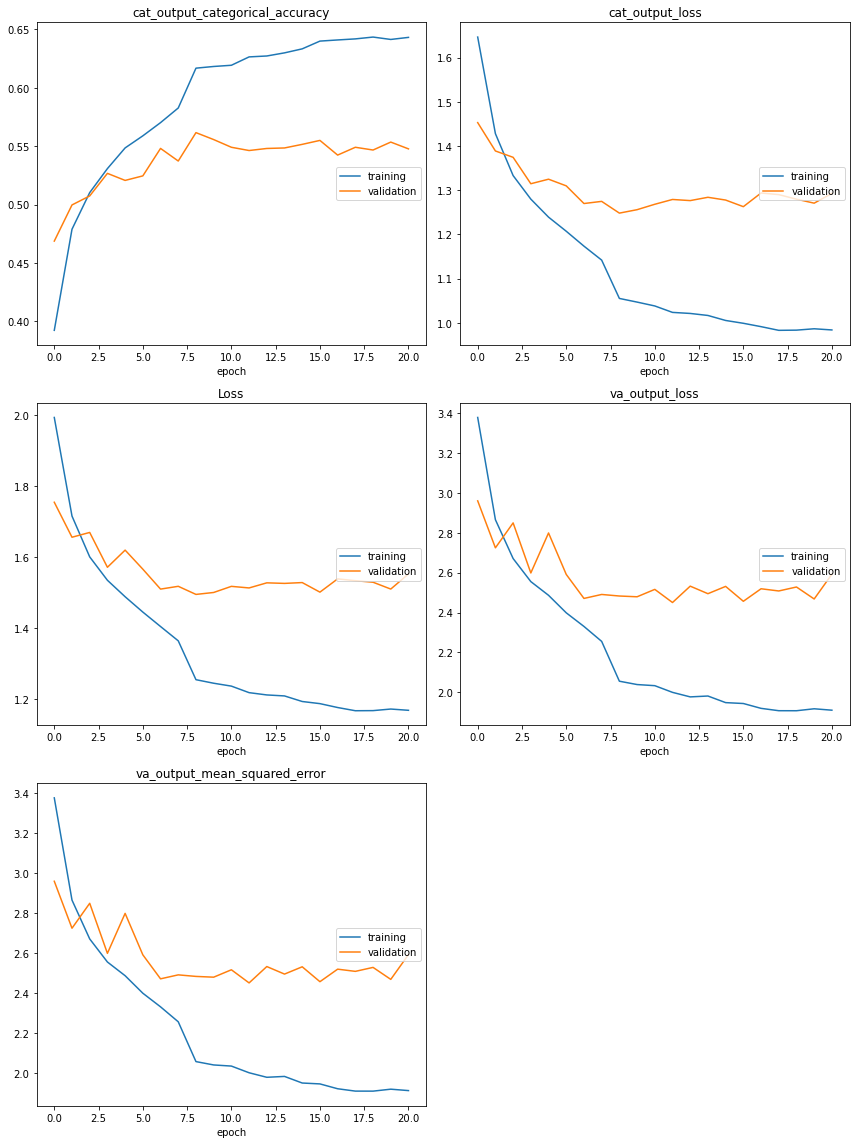

cat_output_categorical_accuracy
	training         	 (min:    0.392, max:    0.643, cur:    0.643)
	validation       	 (min:    0.469, max:    0.562, cur:    0.548)
cat_output_loss
	training         	 (min:    0.983, max:    1.647, cur:    0.984)
	validation       	 (min:    1.248, max:    1.453, cur:    1.293)
Loss
	training         	 (min:    1.168, max:    1.993, cur:    1.169)
	validation       	 (min:    1.495, max:    1.754, cur:    1.553)
va_output_loss
	training         	 (min:    1.908, max:    3.377, cur:    1.911)
	validation       	 (min:    2.450, max:    2.960, cur:    2.592)
va_output_mean_squared_error
	training         	 (min:    1.908, max:    3.377, cur:    1.911)
	validation       	 (min:    2.450, max:    2.960, cur:    2.592)
Epoch 22/25
 17/620 [..............................] - ETA: 11:29 - loss: 1.1629 - cat_output_loss: 0.9691 - va_output_loss: 1.9383 - cat_output_categorical_accuracy: 0.6455 - va_output_mean_squared_error: 1.9383

KeyboardInterrupt: 

In [10]:
EPOCHS = 25
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
    validation_steps=80, # for memory constrains
)
epochs_counter += EPOCHS

Остановил обучение из-за отсутствие прогресса на валидационной выборке (+ перерыв на ночь)

In [11]:
model.save(chpt_dir / 'chpt_last')
# оценка модели после последней эпохи обучения
model.evaluate(val_data_gen, workers=5)

INFO:tensorflow:Assets written to: models/bit-m_va_ds2/chpt_last/assets


INFO:tensorflow:Assets written to: models/bit-m_va_ds2/chpt_last/assets


155/155 [==============================] - 68s 437ms/step - loss: 1.5195 - cat_output_loss: 1.2793 - va_output_loss: 2.4803 - cat_output_categorical_accuracy: 0.5471 - va_output_mean_squared_error: 2.4803


[1.5194979906082153,
 1.2793010473251343,
 2.4802868366241455,
 0.5470974445343018,
 2.4802868366241455]

In [12]:
# evaluate model on the best checkpoint based on val_loss
chpt_dir = Path('models/bit-m_va_ds2/')
model = tf.keras.models.load_model(chpt_dir / 'chpt')
model.evaluate(val_data_gen, workers=5)

155/155 [==============================] - 69s 435ms/step - loss: 1.5154 - cat_output_loss: 1.2727 - va_output_loss: 2.4862 - cat_output_cat_output_categorical_accuracy: 0.5454 - va_output_va_output_mean_squared_error: 2.4862


[1.5153907537460327,
 1.2726927995681763,
 2.486179828643799,
 0.5453811287879944,
 2.486179828643799]

Выгрузим конфигурацию модели в config.ini 

In [39]:
# create config file
import configparser

config = configparser.ConfigParser()
config['MODEL'] = {
    'name': 'BiT-M r50x1 with valence-arousal 2 heads',
    'dataset': 'case1',
    'checkpoint': 'chpt_last'
}
config['IMAGE'] = {
    'size': IMG_SIZE,
    'format': 'RGB',
    'scale': '1 / 255',
}
config['LABELS'] = train_data_gen.class_indices

config['VALENCE_AROUSAL'] = VA_domains

config['OUTPUTS'] = {i: x.name.split('/')[0] for i,x in enumerate(model.outputs)}

with open(chpt_dir / 'config.ini', 'w') as configfile:
    config.write(configfile)

Проведем проверку соответствия выводов регрессора реальным меткам классов. Измеряем растояние предсказания до центра каждой из эмоций, выбираем наименьшее расстояние - предсказание класса по valense-arousal разложению. Далее считаем полную метрику для классификатора и регрессора. Также посмотрим на confusion matrixes для обоих голов модели.

In [42]:
test_metrics = tf.keras.metrics.CategoricalAccuracy()
va_metrics = tf.keras.metrics.CategoricalAccuracy()
class_predictions = []
va_class_predictions = []
true_classes = []
# use converter just to get logits (invert distance) from (valense,arousal) coords
converter = DistanceVAMetric(va_table=val_data_gen.va_table)

for i in tqdm(range(len(val_data_gen))):
    x, y_true = val_data_gen[i]
    y_pred = model(x) # y_pred[0] - classifier output, y_pred[1] - regressor output
    
    va_like_logits = converter._logits_from_va(y_pred[1]) # validate!
    
    va_metrics.update_state(y_true['cat_output'], va_like_logits)
    test_metrics.update_state(y_true['cat_output'], y_pred[0])
    
    va_class_predictions.append(tf.argmax(va_like_logits, axis=1))
    class_predictions.append(tf.argmax(y_pred[0], axis=1))
    true_classes.append(tf.argmax(y_true['cat_output'], axis=1))
    
va_pred = tf.concat(va_class_predictions, axis=0)
class_pred = tf.concat(class_predictions, axis=0)
class_true = tf.concat(true_classes, axis=0)

print(f'Classifier metrics: {test_metrics.result():.4f}')
print(f'Classifier metrics based on valense-arousal: {va_metrics.result():.4f}')

  0%|          | 0/155 [00:00<?, ?it/s]

Classifier metrics: 0.5459
Classifier metrics based on valense-arousal: 0.3683


Confusion matrix для классификатора

In [44]:
categories = list(VA_domains.keys())
print('Строки - реальные метки, столбцы - предсказание')
pd.DataFrame(tf.math.confusion_matrix(class_true, class_pred).numpy(), index=categories, columns=categories)

Строки - реальные метки, столбцы - предсказание


,anger,contempt,disgust,fear,happy,neutral,sad,surprise,uncertain
anger,838,31,90,54,11,140,81,44,88
contempt,30,240,16,2,124,128,14,22,26
disgust,126,8,287,30,27,27,61,11,65
fear,67,2,28,576,17,25,100,169,33
happy,14,118,7,4,843,67,11,43,53
neutral,118,68,12,36,45,695,158,113,101
sad,122,13,31,48,6,175,817,49,72
surprise,29,12,16,174,51,106,36,715,116
uncertain,119,50,63,43,80,155,128,139,396


Confusion matrix для классов на основе регрессора (valense-arousal разложение)

In [45]:
print('Строки - реальные метки, столбцы - предсказание')
pd.DataFrame(tf.math.confusion_matrix(class_true, va_pred).numpy(), index=categories, columns=categories)

Строки - реальные метки, столбцы - предсказание


,anger,contempt,disgust,fear,happy,neutral,sad,surprise,uncertain
anger,423,605,65,40,0,184,36,16,8
contempt,7,101,17,0,24,380,5,61,7
disgust,23,235,193,11,12,121,21,3,23
fear,70,153,20,428,7,183,34,121,1
happy,2,31,18,2,638,319,1,139,10
neutral,30,388,83,15,6,699,64,50,11
sad,66,359,146,14,0,176,552,11,9
surprise,4,74,23,123,63,470,1,482,15
uncertain,38,236,168,12,31,439,36,81,132


Выводы:
- Первый эксперимент считаем провалившимся, несмотря на то, что точность по valense-arousal разложению и превышает порог зачета, определенного заданием, но в то же время значительно ниже результатов классификатора.
- Классификатор часто путает contempt с happy/neutral
- Предсказание по va-разложению сильно путает **anger** c contempt, **contempt** c neutral, **disgust** c contempt, **sad** c contempt, **uncertain** c conpempt/disgust. В общем, явно проблема с идентификацией эмоции contempt.
- Регрессор много предсказывает neutral, но это не особо беспокоит, так как эмоции могут быть ярко выражены либо тускло - собственно слабые эмоции и попадают в категорию neutral. Лучше будет проверить на нескольких примерах позже.

### Вариант 2.

В качестве второго эксперимента обучим модель исключительно как регрессор.

In [22]:
BATCH_SIZE = 64
IMG_SIZE = 240

train_data, val_data, labels_dict = load_dataset(
    n=1, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE
)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.


In [23]:
train_data_gen = ImageGeneratorVA(train_data, VA_domains, two_heads=False)
val_data_gen = ImageGeneratorVA(val_data, VA_domains, two_heads=False)

In [24]:
N_CLASSES = len(train_data_gen.class_indices)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
    hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
    tf.keras.layers.Dense(2, name='va_output', kernel_initializer='zeros'),
])

# BiT HyperRule
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 2000 * 512 / BATCH_SIZE # 11 epochs = 50% of SCHEDULE_LENGTH
SCHEDULE_BOUNDARIES = [int(SCHEDULE_LENGTH * x) for x in [0.3, 0.6, 0.9]] 
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES, 
    values=[lr, lr*0.1, lr*0.02, lr*0.04]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss = tf.keras.losses.MeanSquaredError()
metrics =tf.keras.metrics.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

chpt_dir = Path('models/bit-m_va_ds2/')
chpt_dir.mkdir(parents=True, exist_ok=True)
chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt_reg', save_best_only=True, monitor='val_loss')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
va_output (Dense)            (None, 2)                 4098      
Total params: 23,504,450
Trainable params: 23,504,450
Non-trainable params: 0
_________________________________________________________________


In [25]:
epochs_counter = 0

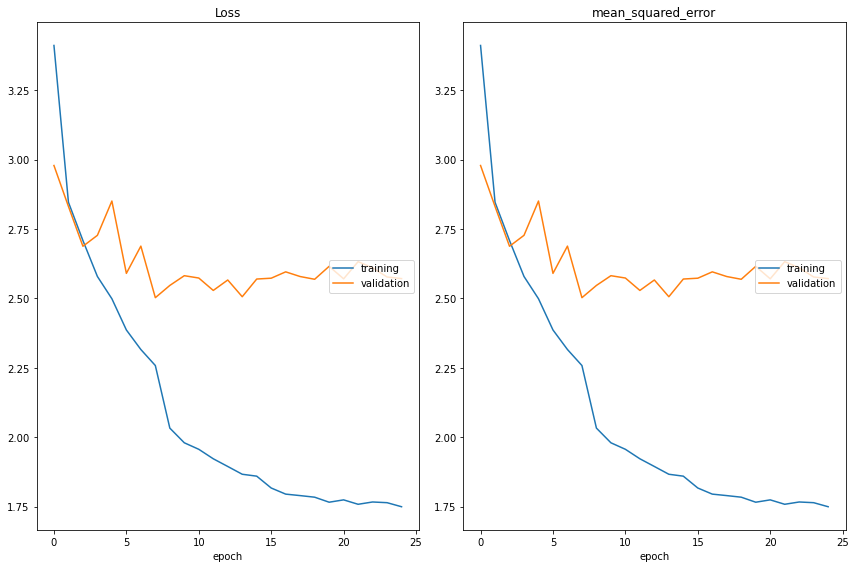

Loss
	training         	 (min:    1.750, max:    3.411, cur:    1.750)
	validation       	 (min:    2.503, max:    2.979, cur:    2.571)
mean_squared_error
	training         	 (min:    1.750, max:    3.411, cur:    1.750)
	validation       	 (min:    2.503, max:    2.979, cur:    2.571)


In [26]:
EPOCHS = 25
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
    validation_steps=80, # for memory constrains
)
epochs_counter += EPOCHS

In [27]:
# оценка модели после последней эпохи обучения
model.evaluate(val_data_gen, workers=5)

INFO:tensorflow:Assets written to: models/bit-m_va_ds2/chpt_last/assets


INFO:tensorflow:Assets written to: models/bit-m_va_ds2/chpt_last/assets


155/155 [==============================] - 66s 424ms/step - loss: 2.6223 - mean_squared_error: 2.6223


[2.622283458709717, 2.622283458709717]

In [28]:
chpt_dir = Path('models/bit-m_va_ds2/')
model = tf.keras.models.load_model(chpt_dir / 'chpt_reg')
model.evaluate(val_data_gen, workers=5)

155/155 [==============================] - 67s 425ms/step - loss: 2.5400 - mean_squared_error: 2.5400


[2.5399818420410156, 2.5399818420410156]

In [102]:
metric = DistanceVAMetric(val_data_gen.va_table)

pred_classes_list = []
true_classes_list = []

for i in tqdm(range(len(val_data_gen))):
    x, y_true = val_data_gen[i]
    y_pred = model(x)
    metric.update_state(y_true, y_pred)
    true_classes_list.append(tf.argmax(metric._logits_from_va(y_true), axis=1))
    pred_classes_list.append(tf.argmax(metric._logits_from_va(y_pred), axis=1))    

class_pred = tf.concat(pred_classes_list, axis=0)
class_true = tf.concat(true_classes_list, axis=0)
print(f'Classifier metrics based on valense-arousal: {metric.result():.4f}')

  0%|          | 0/155 [00:00<?, ?it/s]

Classifier metrics based on valense-arousal: 0.3477


Посмотрим, как изменилась матрица ошибок.

In [147]:
categories = list(VA_domains.keys())
print('\t\t\tМатрица ошибок')
print('\t(Строки - реальные метки, столбцы - предсказания)')
pd.DataFrame(tf.math.confusion_matrix(class_true, class_pred).numpy(), index=categories, columns=categories)

			Матрица ошибок
	(Строки - реальные метки, столбцы - предсказание)


,anger,contempt,disgust,fear,happy,neutral,sad,surprise,uncertain
anger,378,704,44,49,3,179,34,12,4
contempt,6,114,25,0,21,390,2,44,3
disgust,25,283,132,14,5,122,20,8,10
fear,45,176,11,427,9,201,31,106,3
happy,1,35,8,2,637,325,1,154,8
neutral,21,404,59,16,5,731,43,31,12
sad,46,499,136,18,1,184,432,14,9
surprise,7,81,21,146,48,454,0,485,7
uncertain,20,273,152,17,24,488,22,80,108


Вывод: 

- обучение регрессора как под контролем классификатора (первый случай), так и без супервижена дает примерно одинаково посредственный результат, если считать по точности предсказания класса, основанного на евклидовом растоянии предсказания (valense, asousal) до центральных точек различных классов эмоций: 0.3683 (supervised) vs. 0.3477 (unsupervised).
- проблемные классы остались прежними: anger, contempt, disgust, sad, uncertain.

Дополнение: посмотрим не случайные примеры фотографий и предсказаний по valense-arousal.

In [140]:
# немного модифицируем функцию показа под новый генератор и модель
def show_examples(data_gen, converter=None):
    x, y = data_gen[0]
    
    plt.figure(figsize=(15,18))
    plt.suptitle('Quick check of genereted images', fontsize=15).set_y(0.93)
    for i in range(25):
        img = x[i]
        y_pred = model(img[None, ...])
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        label_true = labels_dict[tf.argmax(converter._logits_from_va(y[i:i+1]), axis=1).numpy()[0]]
        title = f"{label_true}\n" +\
                f"v:{y_pred[0][0]:.1f}, a:{y_pred[0][1]:.1f}"
        if not converter is None:
            label_pred = labels_dict[tf.argmax(converter._logits_from_va(y_pred), axis=1).numpy()[0]]
            title += f"\nva_class:{label_pred}"
            color = 'red' if label_true != label_pred else 'black'        
        plt.title(title, color=color)
        plt.xticks([]); plt.yticks([])
        
    plt.subplots_adjust(hspace=0.25)
    plt.show()

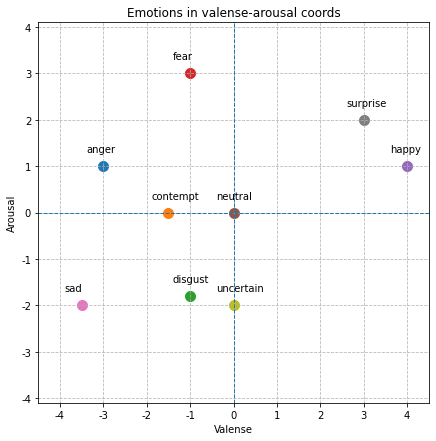

In [130]:
# for reference, as a reminder
emotion_plot(VA_domains)

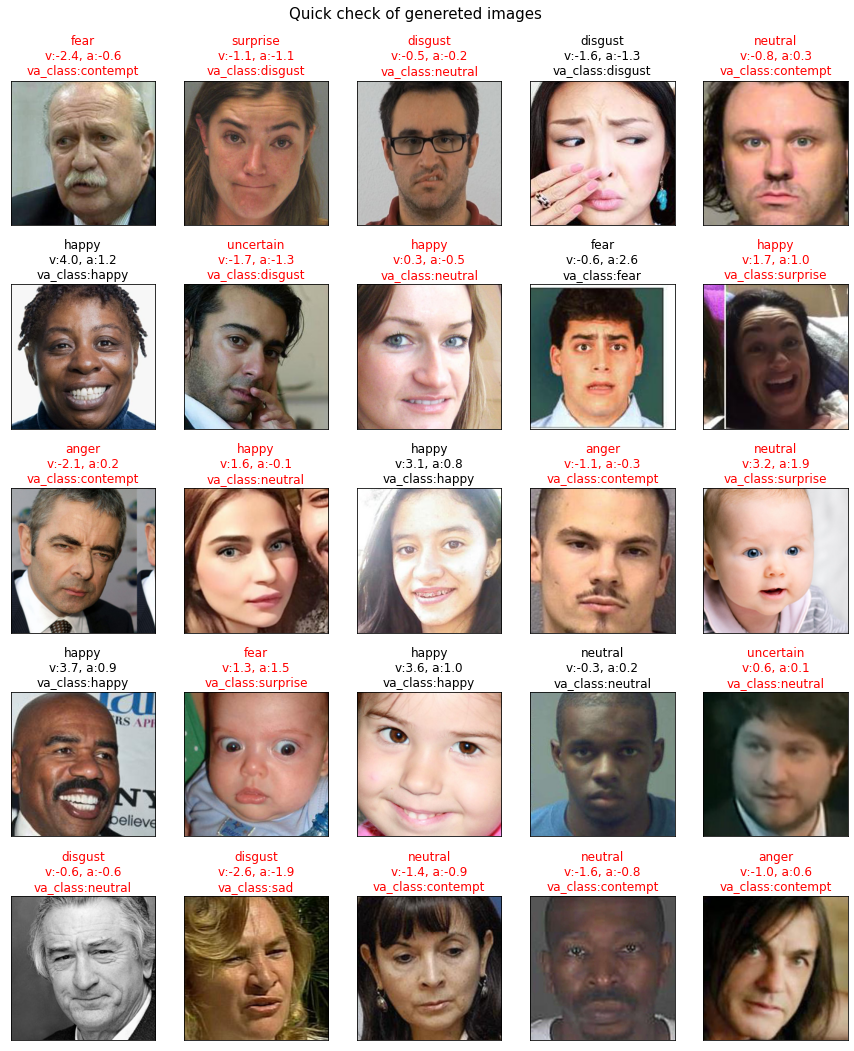

In [141]:
converter = DistanceVAMetric(val_data_gen.va_table)
show_examples(val_data_gen, converter)

**Выводы:**

- В целом, можно заметить, что направление по valesnse (positive/negative) часто предсказано правильно и даже в амплитудой много где можно согласиться. Оценивать arousal (active/pasive) мне сложновато, так как я не понимаю, как нейтральное выражение лица оказывается в середине шкалы active/passive (я бы его в самый пасив поставил - нейтральное выражение лица = нет эмоций, их сила 0).
- Предсказания valense-arousal при должной сноровке могут помочь лучше определять эмоциональное состояние, чем обычная метка класса: например, положительный настрой у человека или отрицательный (по моему субъективному мнению, модель с этой задачей справилась лучше, чем классификатор). 
- Так же модель на регрессии позволяет распознать оттенки эмоций, в отличии от классификатора. Т.е. можно по ходу наблюдения за зрителями вести непрерывный лог по valense и arousal, эти данные усреднять, сравнивать и выводить достоверность того или иного вывода касательно содержимого просматриваемых роликов. Данный подход интересен, но данный датасет не подходит, так как у изображений отсутствует разметка по valense-arousal разложению.
- Еще один вариант использования модели на разложении эмоций: можно на VA-плоскости разметить столько эмоций, сколько необходимо. Проводить перекалибровку значений (центральных точек эмоций) при необходимости без обучения нейроной сети заново.

### Дополнительный эксперимент.

В обоих случаях можно заметить, что модель после нескольких эпох начинала переобучаться. Для борьбы с переобучением введем регуляризацию последнего слоя, как обычно и делали с регрессорами. Также нормируем метки valense-arousal для 9 классов эмоций (иначе от регуляризации может быть мало толку).

In [5]:
VA_domains

{'anger': [-3, 1],
 'contempt': [-1.5, 0],
 'disgust': [-1, -1.8],
 'fear': [-1, 3],
 'happy': [4, 1],
 'neutral': [0, 0],
 'sad': [-3.5, -2],
 'surprise': [3, 2],
 'uncertain': [0, -2]}

In [6]:
mtx = tf.constant([v for v in VA_domains.values()])
va_mean = tf.math.reduce_mean(mtx, axis=0)
va_std  = tf.math.reduce_std(mtx, axis=0)

VA_domains_norm = dict()
for key, value in VA_domains.items():
    VA_domains_norm[key] = \
        ((tf.constant(value, dtype=tf.float32) - va_mean) / va_std).numpy().tolist()
VA_domains_norm

{'anger': [-1.1370705366134644, 0.5091193318367004],
 'contempt': [-0.49746832251548767, -0.07832605391740799],
 'disgust': [-0.2842676043510437, -1.1357276439666748],
 'fear': [-0.2842676043510437, 1.6840099096298218],
 'happy': [1.847739577293396, 0.5091193318367004],
 'neutral': [0.14213381707668304, -0.07832605391740799],
 'sad': [-1.350271224975586, -1.2532168626785278],
 'surprise': [1.4213380813598633, 1.0965646505355835],
 'uncertain': [0.14213381707668304, -1.2532168626785278]}

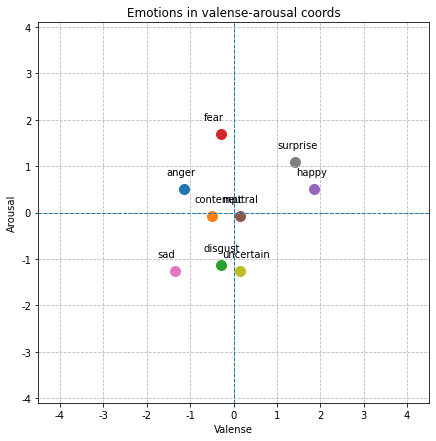

In [29]:
emotion_plot(VA_domains_norm)

In [7]:
BATCH_SIZE = 64
IMG_SIZE = 240

train_data, val_data, labels_dict = load_dataset(
    n=1, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE
)

train_data_gen = ImageGeneratorVA(train_data, VA_domains_norm, two_heads=False)
val_data_gen = ImageGeneratorVA(val_data, VA_domains_norm, two_heads=False)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.


In [8]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
    hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
    tf.keras.layers.Dense(2, name='va_output', kernel_initializer='zeros', kernel_regularizer='l2'),
])

# BiT HyperRule
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 2000 * 512 / BATCH_SIZE # 11 epochs = 50% of SCHEDULE_LENGTH
EPOCHS = int(SCHEDULE_LENGTH // len(train_data_gen)) + 1
SCHEDULE_BOUNDARIES = [int(SCHEDULE_LENGTH * x) for x in [0.3, 0.6, 0.9]] 
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES, 
    values=[lr, lr*0.1, lr*0.03, lr*0.006]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss = tf.keras.losses.MeanSquaredError()
metrics =[DistanceVAMetric(train_data_gen.va_table)]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

chpt_dir = Path('models/bit-m_va_ds2/')
chpt_dir.mkdir(parents=True, exist_ok=True)
chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt_reg_l2', save_best_only=True, monitor='val_loss')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
va_output (Dense)            (None, 2)                 4098      
Total params: 23,504,450
Trainable params: 23,504,450
Non-trainable params: 0
_________________________________________________________________


In [9]:
epochs_counter = 0

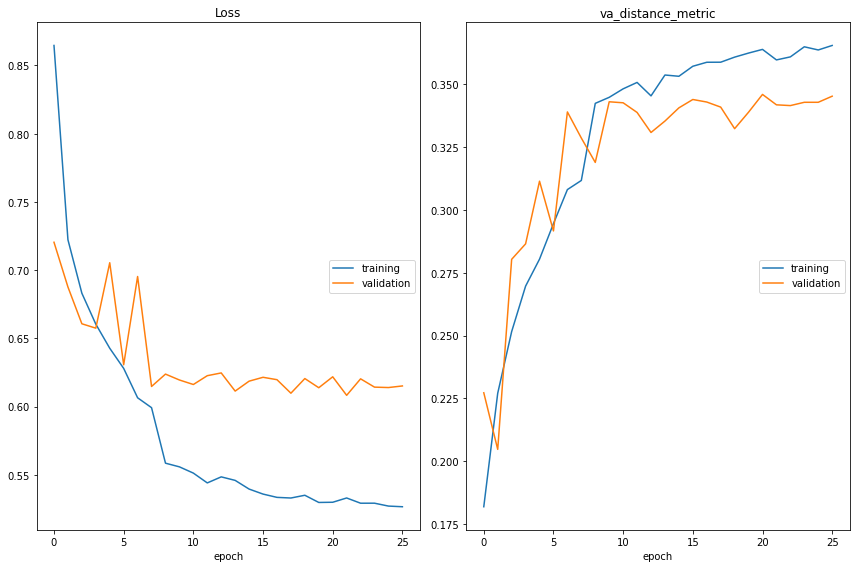

Loss
	training         	 (min:    0.527, max:    0.865, cur:    0.527)
	validation       	 (min:    0.608, max:    0.720, cur:    0.615)
va_distance_metric
	training         	 (min:    0.182, max:    0.365, cur:    0.365)
	validation       	 (min:    0.205, max:    0.346, cur:    0.345)


In [10]:
# EPOCHS = 25
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
#     validation_steps=80, # for memory constrains
)
epochs_counter += EPOCHS

Сравним метрики на валидационной выборке для последней эпохи и с лучший чекпоинт.

In [11]:
chpt_dir = Path('models/bit-m_va_ds2/')
model.save(chpt_dir / 'chpt_reg_l2_last')
model.evaluate(val_data_gen, workers=5)

INFO:tensorflow:Assets written to: models/bit-m_va_ds2/chpt_reg_l2_last/assets


INFO:tensorflow:Assets written to: models/bit-m_va_ds2/chpt_reg_l2_last/assets


155/155 [==============================] - 67s 427ms/step - loss: 0.6197 - va_distance_metric: 0.3403


[0.6196718215942383, 0.34033316373825073]

In [46]:
chpt_dir = Path('models/bit-m_va_ds2/')
# learning with custom metric is more convenient but you can't load compiled model without get_config/from_config methods...
model = tf.keras.models.load_model(chpt_dir / 'chpt_reg_l2', compile=False)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.evaluate(val_data_gen, workers=5)

155/155 [==============================] - 67s 421ms/step - loss: 0.6291 - va_distance_metric: 0.3403


[0.6192840933799744, 0.3402321934700012]

Last checkpoint незначительно лучше.

In [47]:
# create config file
import configparser

config = configparser.ConfigParser()
config['MODEL'] = {
    'name': 'BiT-M r50x1 with valence-arousal regressor',
    'type': 'regression',
    'dataset': 'case1',
    'checkpoint': 'chpt_reg_l2_last',
}
config['IMAGE'] = {
    'size': IMG_SIZE,
    'format': 'RGB',
    'scale': '1 / 255',
}
config['LABELS'] = train_data_gen.class_indices

config['VALENCE_AROUSAL'] = {
    **VA_domains_norm, 
    **{'va_mean':va_mean.numpy().tolist(), 'va_std':va_std.numpy().tolist()}
}

with open(chpt_dir / 'config_reg_l2.ini', 'w') as configfile:
    config.write(configfile)

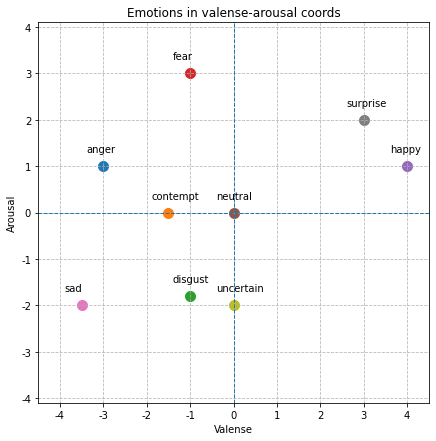

In [27]:
emotion_plot(VA_domains)

In [25]:
# change function to convert normalized (v,a) to original values
def show_examples(data_gen, converter=None):
    x, y = data_gen[0]
    
    plt.figure(figsize=(15,18))
    plt.suptitle('Quick check of genereted images', fontsize=15).set_y(0.93)
    for i in range(25):
        img = x[i]
        y_pred = model(img[None, ...])
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        label_true = labels_dict[tf.argmax(converter._logits_from_va(y[i:i+1]), axis=1).numpy()[0]]
        title = f"{label_true}\n" +\
                f"v:{y_pred[0][0]*va_std[0]+va_mean[0]:.1f}, a:{y_pred[0][1]*va_std[1]+va_mean[1]:.1f}"
        if not converter is None:
            label_pred = labels_dict[tf.argmax(converter._logits_from_va(y_pred), axis=1).numpy()[0]]
            title += f"\nva_class:{label_pred}"
            color = 'red' if label_true != label_pred else 'black'        
        plt.title(title, color=color)
        plt.xticks([]); plt.yticks([])
        
    plt.subplots_adjust(hspace=0.25)
    plt.show()

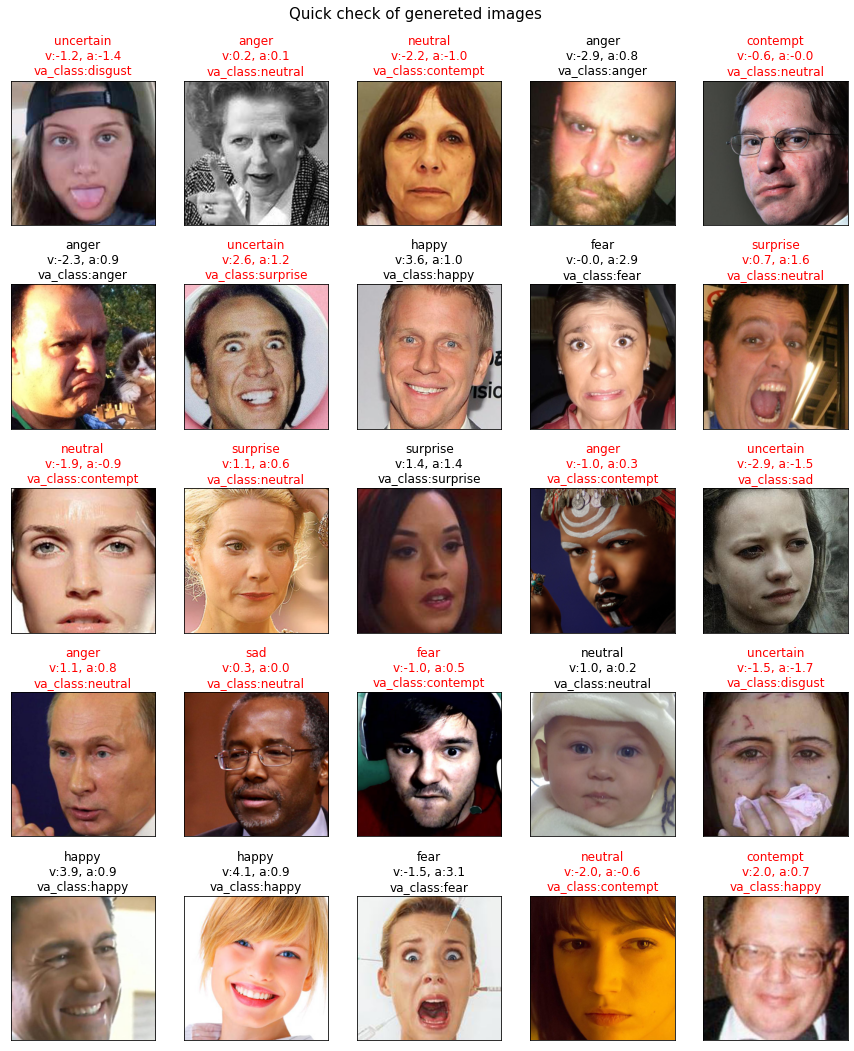

In [26]:
converter = DistanceVAMetric(val_data_gen.va_table)
show_examples(val_data_gen, converter)

Вывод:

регуляризация выходного слоя и нормализация целевых значений не привела к заметным изменениям в точности предсказания класса на основании (valense, arousal), хотя при длительном обучении явных признаков переобучения (роста значения функции потерь на валидационной выборке) нет.